# GAN（生成对抗式网络）

In [18]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 基本概念

GAN的全称是Generative adversarial network，中文翻译过来就是生成对抗网络。生成对抗网络其实是两个网络的组合：生成网络（Generator）负责生成模拟数据；判别网络Discriminator）负责判断输入的数据是真实的还是生成的。生成网络要不断优化自己生成的数据让判别网络判断不出来，判别网络也要优化自己让自己判断得更准确。二者关系形成对抗，因此叫对抗网络。

GAN通过对某一事物大量数据的学习，来学习总结出其在数学层面上的分布规律，构建出合理的映射函数，从而解决现实问题。

![示例图片](../images/p40.png)

生成器(Generator)：通过机器生成数据（大部分情况下是图像），最终目的是“骗过”判别器。

判别器(Discriminator)：判断这张图像是真实的还是机器生成的，目的是找出生成器做的“假数据”。

生成器生成假数据，然后将生成的假数据和真数据都输入判别器，判别器要判断出哪些是真的哪些是假的。判别器第一次判别出来的肯定有很大的误差，然后我们根据误差来优化判别器。现在判别器水平提高了，生成器生成的数据很难再骗过判别器了，所以我们得反过来优化生成器，之后生成器水平提高了，然后反过来继续训练判别器，判别器水平又提高了，再反过来训练生成器，就这样循环往复，直到达到纳什均衡。

**生成网络的损失函数：**
$$L_G=H(1,D(G(z)))$$
上式中，$G$ 代表生成网络，$D $代表判别网络，$H$ 代表交叉熵，$z$ 是输入随机数据。$D(G(z))$是对生成数据的判断概率，1代表数据绝对真实，0代表数据绝对虚假。$H(1,D(G(z)))$代表判断结果与1的距离。显然生成网络想取得良好的效果，那就要做到，让判别器将生成数据判别为真数据（即$D(G(z))$与1的距离越小越好）。

**判别网络的损失函数：**
$$L_D=H(1,D(x))+H(0,D(G(z)))$$
上式中，$x$是真实数据，这里要注意的是，$H(1,D(x))$代表真实数据与1的距离，$H(0,D(G(z)))$代表生成数据与0的距离。显然，识别网络要想取得良好的效果，那么就要做到，在它眼里，真实数据就是真实数据，生成数据就是虚假数据（即真实数据与1的距离小，生成数据与0的距离小）。
 

**优化原理**：生成网络和判别网络有了损失函数，就可以基于各自的损失函数，利用误差反向传播（Backpropagation）(BP)反向传播算法和最优化方法(如梯度下降法)来实现参数的调整），不断提高生成网络和判别网络的性能（最终生成网络和判别网络的成熟状态就是学习到了合理的映射函数）。

## 数据准备

In [148]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [149]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [150]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [151]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader，drop_last这个是对最后的未完成的batch来说的，后面剩余的不够batch_size的会丢弃
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size, drop_last=True)
    return X, y, loader

In [152]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 365
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 22
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 22


## 结果分析

In [153]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GANs")
    plt.legend(["Generator loss", "Discriminator loss"])
    plt.show()

## 模型训练

In [188]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义生成器
    class Generator(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            super(Generator, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional = True)
            self.fc = nn.Linear(hidden_dim*2, out_dim)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out)  
            out = self.sigmoid(out)
            return out

    # 定义判别器
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional = True)
            self.fc = nn.Linear(hidden_dim*2, 1)
            self.sigmoid = nn.Sigmoid() # 二分类

        def forward(self, x):
            out, _ = self.lstm(x)
            out = out[:, -1, :]  # 使用最后一个时间步的输出
            out = self.fc(out)
            out = self.sigmoid(out)
            return out
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    input_dim = 2  # 输入数据的维度
    hidden_dim = 64  # LSTM层的隐藏单元数
    out_dim = 2  # 输出数据的维度
    batch_size = 64
    seq_length = 6
    lr = 0.001  # 学习率

    generator = Generator(input_dim, hidden_dim, out_dim)
    discriminator = Discriminator(input_dim, hidden_dim)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

    # 定义损失函数
    loss_fn = nn.BCELoss()
    
    # 损失函数值
    G_losses, D_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        generator.train()
        discriminator.train()
        total_G_loss = 0
        total_D_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将输入数据和标签移至GPU
            inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
            
            # 训练生成器
            optimizer_G.zero_grad()
            # 生成器的输入可以是随机噪声等，均值为0，方差为1的正态分布随机数
            fake_data = generator(torch.rand(batch_size, seq_length, input_dim).to(device))  # 64个序列，每个序列长度为6
            fake_labels = torch.zeros(batch_size, 1)  # 生成器生成的数据标签为0，表示生成的数据
            loss_G = loss_fn(discriminator(fake_data), fake_labels)
            loss_G.backward()
            optimizer_G.step()

            # 训练判别器
            optimizer_D.zero_grad()
            real_data = inputs_batch # 实际数据
            real_labels = torch.ones(batch_size, 1)  # 真实数据的标签为1，表示真实数据
            loss_real = loss_fn(discriminator(real_data), real_labels) # 判定为真的损失
            # 判别器对生成器生成的数据的损失
            # .detach()的作用是防止梯度回传到生成器，因为在这里我们只关心判别器的损失。
            loss_fake = loss_fn(discriminator(fake_data.detach()), fake_labels)  # 判定为假的损失
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()
            
            #每个batch的loss和
            total_G_loss += loss_G.item()
            total_D_loss += loss_D.item()
                
        #每个epoch的损失平均
        avg_G_loss = total_G_loss / len(train_loader)
        avg_D_loss = total_D_loss / len(train_loader)
        
        #所有epoch的loss
        G_losses.append(avg_G_loss)
        D_losses.append(avg_D_loss)
            
        print(f'Epoch [{epoch}/{n_epochs}], Generator Loss: {avg_G_loss:.4f}, Discriminator Loss: {avg_D_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(G_losses, D_losses)
        
    return generator

 10%|████████▎                                                                          | 1/10 [00:08<01:12,  8.01s/it]

Epoch [0/10], Generator Loss: 0.0873, Discriminator Loss: 0.0853


 20%|████████████████▌                                                                  | 2/10 [00:16<01:04,  8.06s/it]

Epoch [1/10], Generator Loss: 0.0003, Discriminator Loss: 0.0003


 30%|████████████████████████▉                                                          | 3/10 [00:24<00:56,  8.04s/it]

Epoch [2/10], Generator Loss: 0.0001, Discriminator Loss: 0.0001


 40%|█████████████████████████████████▏                                                 | 4/10 [00:32<00:48,  8.05s/it]

Epoch [3/10], Generator Loss: 0.0001, Discriminator Loss: 0.0001


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:40<00:40,  8.04s/it]

Epoch [4/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:48<00:33,  8.27s/it]

Epoch [5/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:57<00:25,  8.43s/it]

Epoch [6/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:06<00:17,  8.52s/it]

Epoch [7/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:14<00:08,  8.39s/it]

Epoch [8/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.26s/it]

Epoch [9/10], Generator Loss: 0.0000, Discriminator Loss: 0.0000


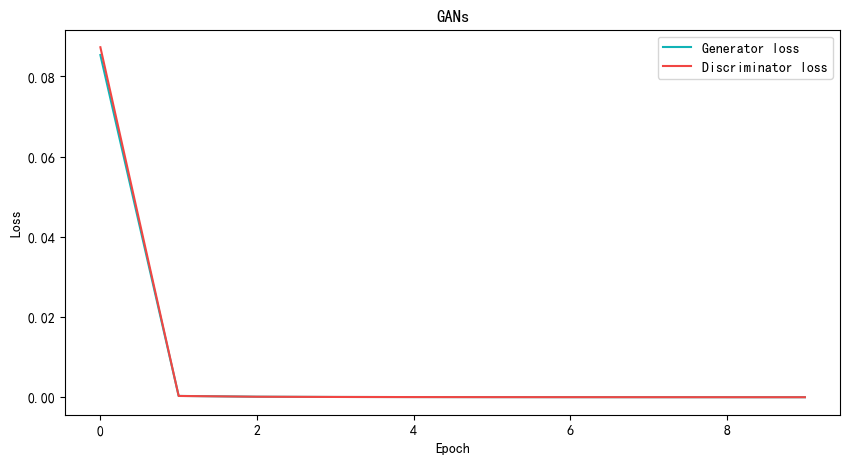

In [189]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "plots": True,
}
generator = train(**params3)

## 数据生成

In [179]:
# 生成单步数据
def generator_(data, seq_length, out_dim, num_samples, scaler, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
#         # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
#         k = np.random.randint(0, nums-seq_length) # 随机生成一个整数
#         input_data = torch.tensor(data[k:k+seq_length, :]).unsqueeze(0) # 随机抽样
#         input_data = input_data.to(device) # 将数据应用到GPU
#         # 确保梯度不变
#         with torch.no_grad():
#             model.eval()
#             y_pred = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_length, out_dim))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [180]:
# 生成时序数据
params6 = {
    "data": ts_data,
    "seq_length": 6,
    "out_dim": 2,
    "num_samples": 10,
    "scaler": scaler,
    "model": generator,
}
new_data = generator_(**params6)

In [181]:
new_data

array([[5212.58,  -13.23],
       [5212.42,  -13.23],
       [5212.62,  -13.24],
       [5213.06,  -13.25],
       [5212.68,  -13.23],
       [5212.5 ,  -13.24],
       [5212.51,  -13.24],
       [5212.75,  -13.23],
       [5213.43,  -13.24],
       [5212.58,  -13.23]], dtype=float32)

In [190]:
# 假设 generator 是已经训练好的生成器模型
generator.eval()  # 将生成器切换到评估模式，确保不再进行梯度计算

# 生成随机噪声作为输入
random_noise = torch.rand(1, 6, 2)

# 使用生成器生成数据
generated_data = generator(random_noise)

# generated_data 现在包含了生成器生成的数据


In [191]:
scaler.inverse_transform(generated_data.squeeze().detach().numpy())

array([[5215.87,  -13.16],
       [5218.55,  -13.38],
       [5219.98,  -13.52],
       [5219.27,  -13.56],
       [5213.57,  -13.5 ],
       [5203.14,  -13.38]], dtype=float32)

In [160]:
generated_data

tensor([[[0.9970, 0.0034],
         [0.9976, 0.0028],
         [0.9975, 0.0029],
         [0.9972, 0.0037],
         [0.9969, 0.0047],
         [0.9958, 0.0061]]], grad_fn=<SigmoidBackward0>)

In [122]:
# 产生随机噪声
latent_noise = torch.randn(1, 6, 2)

# 在生成器前向传播中不跟踪梯度
with torch.no_grad():
    # 通过生成器生成数据
    generator.eval()
    generated_data = generator(latent_noise)

In [123]:
generated_data

tensor([[[8.8322e-01, 9.3992e-02],
         [9.9912e-01, 2.9040e-04],
         [9.9999e-01, 1.1246e-06],
         [1.0000e+00, 4.3052e-07],
         [1.0000e+00, 3.8304e-07],
         [1.0000e+00, 3.7671e-07]]])

如果生成的数据是同一个值，这可能是生成器陷入了模式崩溃（Mode Collapse）的情况。模式崩溃是指生成器倾向于生成相似或相同的样本，而不是多样性的输出。这可能是GAN训练中的一种常见问题。

以下是一些可能的解决方法：

增加生成器和判别器的复杂性：

考虑增加生成器和判别器的容量，例如增加隐藏单元的数量、增加层数等。这有助于提高模型的表达能力，防止模式崩溃。
使用其他的GAN变体：

尝试使用其他GAN的变体，如WGAN（Wasserstein GAN）、LSGAN（Least Squares GAN）等。这些变体对于某些稳定性问题有更好的性能。
尝试不同的优化器和学习率：

调整生成器和判别器的优化器、学习率和其他超参数。有时候，改变优化器或学习率可以改善训练的稳定性。
实施正则化技术：

添加正则化技术，如批量归一化（Batch Normalization）或正则化项，以促使模型学习更稳定的表示。
改变损失函数：

尝试不同的损失函数，有时候使用不同的损失函数可以改善模型的训练表现。
增加噪声：

在训练中引入一些噪声，有时可以帮助模型避免陷入同一模式的问题。
监控生成器和判别器的损失：

通过监控生成器和判别器的损失来检查训练进程。如果发现损失不断变化而不收敛，可能需要调整超参数或模型架构。
调整数据集：

确保你的训练数据集具有足够的多样性，以便模型能够学到不同的模式。

# VAE（变分自编码器）

详见时间序列预测Ⅳ，第七章7.5.8

## 数据准备

In [60]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [ ]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [61]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [62]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader，drop_last这个是对最后的未完成的batch来说的，后面剩余的不够batch_size的会丢弃
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size, drop_last=False)
    return X, y, loader

In [63]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 366
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23


## 结果分析

In [64]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

## 模型训练

In [65]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义变分自编码器模型
    class VAE(nn.Module):
        def __init__(self, input_dim, hidden_dim, latent_dim):
            super(VAE, self).__init__()

            # Encoder
            self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于编码输入序列
            self.fc_mean = nn.Linear(hidden_dim*2, latent_dim) # 输出均值
            self.fc_logvar = nn.Linear(hidden_dim*2, latent_dim) # 输出对数方差

            # Decoder
            self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于解码潜在表示
            self.fc_output = nn.Linear(hidden_dim*2, input_dim) # 输出重建的序列

        def encode(self, x):
            x, (encoder_hidden, encoder_cell) = self.encoder_lstm(x)  # LSTM编码器的输出
            mean = self.fc_mean(x) # 计算均值
            logvar = self.fc_logvar(x) # 计算对数方差
            return mean, logvar, encoder_hidden, encoder_cell

        def reparameterize(self, mean, logvar):
            std = torch.exp(0.5 * logvar) # 计算标准差
            eps = torch.randn_like(std) # 从标准正态分布中采样噪声，并生成一个与输入张量形状相同的张量，目的是对抗
            return mean + eps * std # 重新参数化，随着损失函数变小，使其服从标准正态分布

        def decode(self, z):
            decoder_hidden, decoder_cell = self.encoder_hidden, self.encoder_cell
            x, _ = self.decoder_lstm(z, (decoder_hidden, decoder_cell))  # z服从标准正态分布
            x = self.fc_output(x) # 输出重建的序列
            return x

        def forward(self, x):
            mean, logvar, self.encoder_hidden, self.encoder_cell = self.encode(x) # 编码输入序列
            z = self.reparameterize(mean, logvar) # 重参数化，形状为(batch_size, seq_length, latent_dim)
            x_recon = self.decode(z) # 解码潜在表示
            return x_recon, mean, logvar

    # 定义变分自编码器的损失函数
    def vae_loss(x_recon, x, mean, logvar):
        # 重建损失（MSE损失）
        recon_loss = nn.functional.mse_loss(x_recon, x)

        # KL散度损失，KL散度通常用于衡量潜在空间中的编码分布与先验分布（通常是标准正态分布）之间的差异。
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) # 散度越小意味着两个分布越接近

        return recon_loss + kl_loss
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    input_dim = 2  # 输入数据的维度
    hidden_dim = 64  # LSTM层的隐藏单元数
    latent_dim = 16  # 潜在空间的维度
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            x_recon, mean, logvar = model(inputs_batch)
            train_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                x_recon, mean, logvar = model(inputs_batch)
                val_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

 10%|████████▎                                                                          | 1/10 [00:05<00:48,  5.41s/it]

Epoch [1/10], Training Loss: 0.2539, Validation Loss: 0.0101


 20%|████████████████▌                                                                  | 2/10 [00:11<00:44,  5.58s/it]

Epoch [2/10], Training Loss: 0.0027, Validation Loss: 0.0036


 30%|████████████████████████▉                                                          | 3/10 [00:16<00:39,  5.66s/it]

Epoch [3/10], Training Loss: 0.0015, Validation Loss: 0.0028


 40%|█████████████████████████████████▏                                                 | 4/10 [00:22<00:34,  5.72s/it]

Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0023


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:28<00:28,  5.78s/it]

Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0019


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:34<00:23,  5.79s/it]

Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0017


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:40<00:17,  5.76s/it]

Epoch [7/10], Training Loss: 0.0007, Validation Loss: 0.0015


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:45<00:11,  5.76s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0015


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:51<00:05,  5.77s/it]

Epoch [9/10], Training Loss: 0.0006, Validation Loss: 0.0014


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.73s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0013


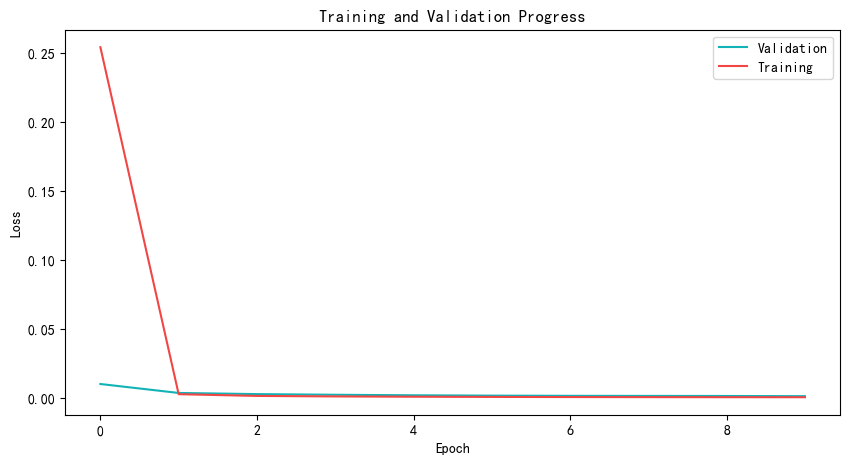

In [66]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

## 数据生成

In [67]:
# 生成单步数据
def generator(data, seq_length, latent_dim, num_samples, scaler, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组
    seq_length = seq_length
    latent_dim = latent_dim

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_length) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_length, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        with torch.no_grad():
            model.eval()
            y_pred, mean, logvar = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_length, latent_dim))  
        new_input_data = new_input_data.to(device) 
        with torch.no_grad():
            model.eval()
            generated_samples = model.decode(new_input_data)
            generated_samples = generated_samples[:, -1, :] # 取最后一组数据
            generated_samples = generated_samples.cpu().detach().numpy()
            generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
            samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [68]:
# 生成时序数据
params6 = {
    "data": ts_data,
    "seq_length": 6,
    "latent_dim": 16,
    "num_samples": 3000,
    "scaler": scaler,
    "model": model,
}
new_data = generator(**params6)

## 分布差异

<Axes: ylabel='Density'>

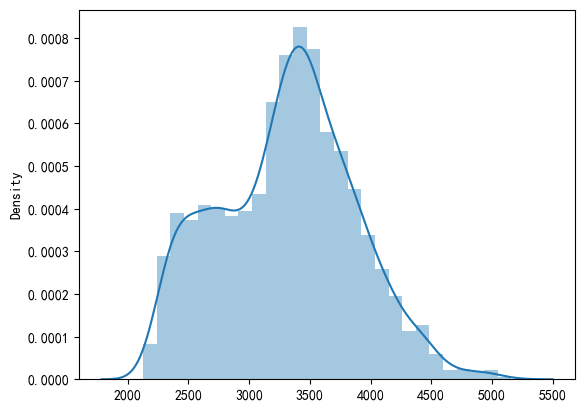

In [72]:
sns.distplot(new_data[:,0]) # 生成的数据分布

<Axes: ylabel='Density'>

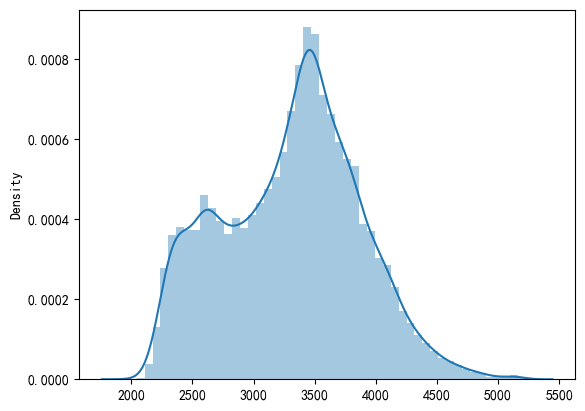

In [73]:
sns.distplot(ts_data['load'].values) # 原始的数据分布

KL散度: 0.06708296180865164


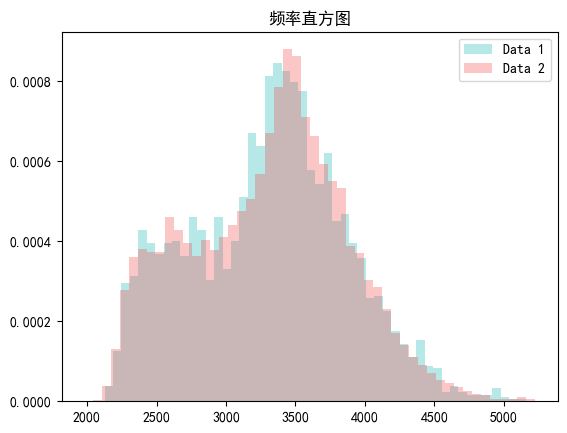

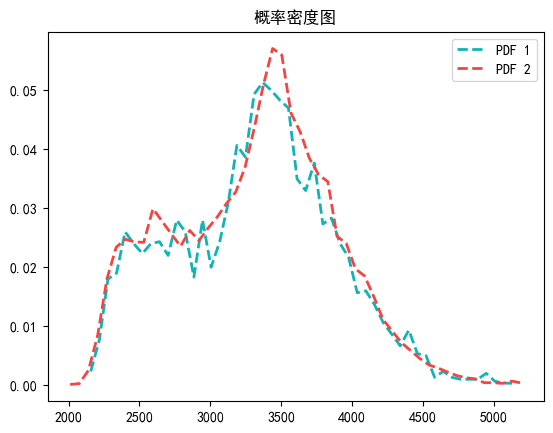

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL散度:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 
plt.title('频率直方图')

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
# 显示图例和标题
plt.legend()
plt.title('概率密度图')

plt.show()